In [1]:
def importdata():
    df = pd.read_csv('../data/final_df_points_18_21.csv')
    #df['time_start'] = pd.to_datetime(df['time_start'])
    return df

In [2]:
def create_onedf_hexid(df,hex_id):
    onedfhexid = pd.DataFrame(columns=df.columns)
    for ind in tqdm(df.index):
        if df['hex_id'][ind] == hex_id:
            onedfhexid.loc[df.index[ind]] = df.iloc[ind]
            #onedfhexid.append(df[ind], ignore_index = True)
    return onedfhexid.reset_index(drop=True)

In [3]:
def create_tsdata(_year,_days):
    rng = pd.date_range(f'{_year}-01-01', periods=_days, freq='D')
    tsdata = pd.DataFrame({ 'date': rng, 'idle_time' : np.nan, 'list': np.nan, 'bike_count': np.nan}) 
    return tsdata.set_index('date')

In [4]:
def add_rows_to_days(tsdata,onedfhexid):
    # iteriere über alle Tage
    for date in tqdm(tsdata.index):
        list = []
        # Adde alle Rows in die List wenn Tag = Tag
        for ind in onedfhexid.index:
            if date.date() == onedfhexid['dt_start'][ind].date():
                list.append(onedfhexid['timestood'][ind])
        #print(len(list))        
        # Setze Mittelwert für Tage
        if len(list) == 0:
            tsdata['bike_count'][date] = 1
            continue
        else:
            tsdata['bike_count'][date] = len(list)
            tsdata['idle_time'][date] = statistics.mean(list)
    return tsdata

In [5]:
def get_rows_one_day(day,onedfhexid):
    list=[]
    for ind in onedfhexid.index:
        if day == onedfhexid['time_start'][ind].date():
            list.append(onedfhexid['timestood'][ind])
    print(list)
    print(statistics.mean(list))

In [6]:
def roling_weighted_mean(tsdata,_year,_days):
    x = []
    rng2 = pd.date_range(f'{_year}-01-01', periods=_days, freq='D')
    data_mean2 = pd.DataFrame({ 'date': rng2, 'idle_time' : np.nan})
    data_mean2 = data_mean2.set_index('date')
    
    for window in tsdata.rolling(window = 7 , center = True):
        #print(window)
        x.append(np.average(window['idle_time'], weights = window['bike_count']))
    
    data_mean2['idle_time'] = x
    return data_mean2

In [7]:
def plot(x):
    fig, ax1 = plt.subplots(figsize = (20,10))
    
    ax1.plot(x['idle_time'], linewidth=2,color='red', label='Idle Time Mean')
    ax1.set_xlabel('day')
    ax1.set_ylabel('timestood (min)')
    ax1.tick_params(axis ='y', labelcolor = 'red') 
    
    ax2 = ax1.twinx()
    ax2.plot(x['bike_count'], linewidth=2, label='bike_count')
    ax2.set_ylabel('bike_count')
    ax2.tick_params(axis ='y', labelcolor = 'blue')
    
    plt.show()

In [8]:
def plot_details(tsdata,data_7d_rol,data_2m_rol,data_7d_mean2,hex_id,total_bike_count):
    fig, ax = plt.subplots(figsize = (20,10))
    
    # plotting daily data
    ax.plot(tsdata['idle_time'], marker='.', markersize=2, color='0.6',linestyle='None', label='Daily')
    # plotting 7-day rolling data
    ax.plot(data_7d_rol['idle_time'],color = 'blue', linewidth=2, label='7-d Rolling Mean')
    ax.plot(data_7d_mean2['idle_time'],color = 'green', linewidth=2, label='7-d Rolling Mean')
    # plotting 2-Month rolling data -trend-
    ax.plot(data_2m_rol['idle_time'], color='0.2', linewidth=3, label='Trend (2M)')
    ax.legend()
    ax.set_xlabel('day')
    ax.set_ylabel('timestood (min)')
    ax.set_title(f'Trends in idel time of bikes in hex: {hex_id} with a total of {total_bike_count} rentals')
    
    ax2 = ax.twinx()
    ax2.plot(data_7d_rol['bike_count'],linewidth=1, color='0.5',label='Bike Count 7-d RM')
    ax2.set_xlabel('day')
    ax2.set_ylabel('bikes in hex per day')
    ax2.legend()
    
    plt.show()

In [9]:
def fix_missing_values(tsdata):
    data_freq = tsdata.asfreq('D')
    data_freq = data_freq.ffill()
    return data_freq

# Main

In [10]:
import pandas as pd
pd.options.mode.chained_assignment = None
from tqdm import tqdm
from datetime import timedelta, datetime, date
pd.set_option('display.max_rows', None)
import weightedstats

import numpy as np
import statistics
import matplotlib.pyplot as plt

### Define the HEX_id

#hex_id = '8a1f1a8d9d97fff'
#hex_id = '8a1f1a8cb4cffff'
#hex_id = '8a1f1a8cb4dffff'
#hex_id = '8a1f1a8cb71ffff'
hex_id = '881f1a8cb7fffff'

days=1460
year=2018
data_columns = ['idle_time','bike_count']


In [11]:
df = importdata()

In [12]:
df.head()

,bike_id,lat,lng,dt_start,dt_end,hex_id,in_zone,zone_name,end_station_number,temp,...,snow,wind_speed,humidity,year,month,day,start_min,over_night,idle_time_next_day,idle_time
0,3694,51.323619,12.335887,1514764029,1514764799,881f1a8d91fffff,1,Pinke Zone Leipzig West 1€,4094,10.80,...,0.0,7.2,76.0,2017,12,6,1427,1,821,12
1,2508,51.323619,12.335887,1514764035,1514764799,881f1a8d91fffff,1,Pinke Zone Leipzig West 1€,4094,10.80,...,0.0,7.2,76.0,2017,12,6,1427,1,1439,12
2,41851,51.332415,12.395158,1514764638,1514764799,881f1a1659fffff,1,Pinke Zone Leipzig Ost 1€,0,10.80,...,0.0,7.2,76.0,2017,12,6,1437,1,1439,2
3,3694,51.323619,12.335887,1514764800,1514814103,881f1a8d91fffff,1,Pinke Zone Leipzig West 1€,4094,10.86,...,0.0,9.3,76.0,2018,1,0,0,0,0,821
4,2508,51.323619,12.335887,1514764800,1514851199,881f1a8d91fffff,1,Pinke Zone Leipzig West 1€,4094,10.86,...,0.0,9.3,76.0,2018,1,0,0,1,878,1439


In [13]:
onedfhexid = create_onedf_hexid(df,hex_id)

100%|██████████| 2543830/2543830 [27:38<00:00, 1533.45it/s] 


In [14]:
# create tsdata

tsdata = create_tsdata(year,days)
tsdata = add_rows_to_days(tsdata,onedfhexid)


  0%|          | 0/1460 [00:00<?, ?it/s]


KeyError: 'time_start'

In [ ]:
tsdata.to_csv('../data/ts_data_hex_881f1a8cb7fffff_3y.csv')

In [ ]:
# Import tsdata
#tsdata = pd.read_csv('../data/ts_data_hex_881f1a8cb7fffff_3y.csv')
tsdata.head()

In [ ]:
tsdata = fix_missing_values(tsdata)
total_bike_count = int(tsdata['bike_count'].sum())

data_7d_rol = tsdata[data_columns].rolling(window = 7, center = True).mean()
data_2m_rol = tsdata[data_columns].rolling(window = 60, center = True).mean()
data_7d_mean2 = roling_weighted_mean(tsdata,year,days)

plot_details(tsdata,data_7d_rol,data_2m_rol,data_7d_mean2,hex_id,total_bike_count)

# Begin Predicition

In [17]:
dfw = pd.read_csv('/Users/jonweske/devment/BA_nextbike/data/weather_data.csv')
dfw['datetime'] = pd.to_datetime(dfw['dt'], unit='s')
dfw = dfw.set_index(['datetime'])
dfw.head()

tsdata['temp'] = np.nan
tsdata['rain'] = np.nan
tsdata['snow'] = np.nan


for ind in tqdm(tsdata.index):
    wint = ind.replace(hour=12,minute=0,second=0)
    tsdata['temp'][ind] = dfw['temp'][wint].copy()
    tsdata['rain'][ind] = dfw['rain_1h'][wint].copy()
    tsdata['snow'][ind] = dfw['snow_1h'][wint].copy()

100%|██████████| 1364/1364 [00:01<00:00, 1257.53it/s]


In [18]:
#del tsdata['list']
tsdata.head()

,idle_time,list,bike_count,temp,rain,snow
date,,,,,,
2018-01-01,509.500000,NaN,2.0,8.67,NaN,NaN
2018-01-02,536.714286,NaN,7.0,5.11,NaN,NaN
2018-01-03,919.000000,NaN,9.0,6.11,NaN,NaN
2018-01-04,753.615385,NaN,13.0,8.11,NaN,NaN
2018-01-05,764.000000,NaN,15.0,10.11,NaN,NaN


In [15]:
import sklearn.metrics as metrics

def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    #mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    #median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))

In [21]:
# Feature Engeniering
# inserting new column with yesterday last_week and last_year plus Diffs
tsdata['Yesterday'] = tsdata['idle_time'].shift()
tsdata['Yesterday_Diff'] = tsdata['Yesterday'].diff()

tsdata['Last_Week'] = tsdata['idle_time'].shift(periods=7)
tsdata['Last_Week_Diff'] = tsdata['Last_Week'].diff()

tsdata['Last_Year'] = tsdata['idle_time'].shift(periods=365)
tsdata['Last_Year_Diff'] = tsdata['Last_Year'].diff()

# Nan s to 0 
tsdata = tsdata.fillna(0)

In [114]:
data_consumption['rain'].max()

25.4

In [23]:
tsdata.head()

,idle_time,list,bike_count,temp,rain,snow,Yesterday,Yesterday_Diff,Last_Week,Last_Week_Diff,Last_Year,Last_Year_Diff
date,,,,,,,,,,,,
2018-01-01,509.500000,0.0,2.0,8.67,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
2018-01-02,536.714286,0.0,7.0,5.11,0.0,0.0,509.500000,0.000000,0.0,0.0,0.0,0.0
2018-01-03,919.000000,0.0,9.0,6.11,0.0,0.0,536.714286,27.214286,0.0,0.0,0.0,0.0
2018-01-04,753.615385,0.0,13.0,8.11,0.0,0.0,919.000000,382.285714,0.0,0.0,0.0,0.0
2018-01-05,764.000000,0.0,15.0,10.11,0.0,0.0,753.615385,-165.384615,0.0,0.0,0.0,0.0


In [25]:
TargetVariable = ['idle_time']
Predictors = ['bike_count', 'temp', 'rain', 'snow', 'Yesterday', 'Yesterday_Diff', 'Last_Week', 'Last_Week_Diff', 'Last_Year', 'Last_Year_Diff']

X = tsdata[Predictors].values
y = tsdata[TargetVariable].values

### Sandardization of data ###
from sklearn.preprocessing import StandardScaler

PredictorScaler = StandardScaler()
TargetVarScaler = StandardScaler()

# Storing the fit object for later reference
PredictorScalerFit = PredictorScaler.fit(X)
TargetVarScalerFit = TargetVarScaler.fit(y)

# Generating the standardized values of X and y
X = PredictorScalerFit.transform(X)
y = TargetVarScalerFit.transform(y)

# Split the data into training and testing set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Quick sanity check with the shapes of Training and testing datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1091, 10)
(1091, 1)
(273, 10)
(273, 1)


LR: 0.804851 (0.077520)
NN: 0.595037 (0.278094)
KNN: 0.734869 (0.096598)
RF: 0.786302 (0.078311)
SVR: 0.755564 (0.079866)


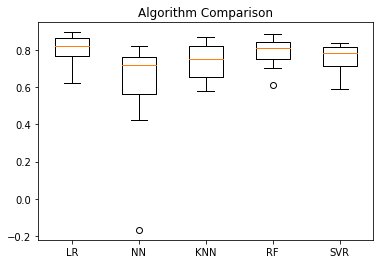

In [27]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score

import warnings
from sklearn.exceptions import ConvergenceWarning


# Spot Check Algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('NN', MLPRegressor(solver = 'lbfgs')))  #neural network
models.append(('KNN', KNeighborsRegressor())) 
models.append(('RF', RandomForestRegressor(n_estimators = 10))) # Ensemble method - collection of many decision trees
models.append(('SVR', SVR(gamma='auto'))) # kernel = linear
# Evaluate each model in turn
results = []
names = []
for name, model in models:
    # TimeSeries Cross validation
    tscv = TimeSeriesSplit(n_splits=10)
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=ConvergenceWarning)
        cv_results = cross_val_score(model, X_train, y_train.ravel(), cv=tscv, scoring='r2')
        
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

# Testing GridSearching

In [1]:
from sklearn.metrics import make_scorer

def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    return score

rmse_score = make_scorer(rmse, greater_is_better = False)

In [2]:
from sklearn.model_selection import GridSearchCV

model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = rmse_score)
gsearch.fit(X_train, y_train.ravel())
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

NameError: name 'RandomForestRegressor' is not defined

In [38]:
y_true = y_test
y_pred = best_model.predict(X_test)

regression_results(y_true, y_pred)

explained_variance:  0.84
r2:  0.8388
MAE:  0.2628
MSE:  0.1924
RMSE:  0.4386


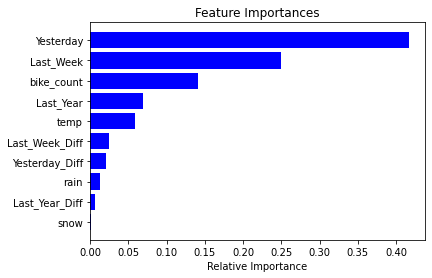

In [36]:
imp = best_model.feature_importances_
X_train = pd.DataFrame(X_train,columns=['bike_count', 'temp', 'rain', 'snow', 'Yesterday', 'Yesterday_Diff', 'Last_Week', 'Last_Week_Diff', 'Last_Year', 'Last_Year_Diff'])
features = X_train.columns
indices = np.argsort(imp)
plt.title('Feature Importances')
plt.barh(range(len(indices)), imp[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# variable importance plot